In [1]:
import os
import sys
import random
import torch
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
sys.path.append("..")

In [3]:
os.cpu_count()

64

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.device_count()

4

In [6]:
from carca.data import CARCADataset, load_attrs, load_ctx, load_profiles
from carca.model import CARCA
from carca.train import train, evaluate

In [7]:
attrs = load_attrs("video_games")
ctx = load_ctx("video_games")
user_ids, item_ids, profiles = load_profiles("video_games")

In [8]:
n_items = len(item_ids) + 1
n_ctx = next(iter(ctx.values())).shape[0]
n_attrs = attrs.shape[1]

In [9]:
# Hyper-parameters for Games dataset
learning_rate =  0.0001
seq_len = 50
n_blocks = 3
n_heads = 3
dropout_rate = 0.5
l2_reg = 0.0
d_dim = 90
g_dim = 450
residual_sa = True
residual_ca = True
epochs = 800
batch_size = 128
beta1 = 0.9
beta2 = 0.98

In [10]:
train_data = CARCADataset(
    user_ids=user_ids,
    item_ids=item_ids,
    profiles=profiles,
    attrs=attrs,
    ctx=ctx,
    profile_seq_len=seq_len,
    target_seq_len=100,
    mode="train"
)
val_data = CARCADataset(
    user_ids=user_ids,
    item_ids=item_ids,
    profiles=profiles,
    attrs=attrs,
    ctx=ctx,
    profile_seq_len=seq_len,
    target_seq_len=100,
    mode="val"
)
test_data = CARCADataset(
    user_ids=user_ids,
    item_ids=item_ids,
    profiles=profiles,
    attrs=attrs,
    ctx=ctx,
    profile_seq_len=seq_len,
    target_seq_len=100,
    mode="test"
)

val_idx = random.sample(range(len(val_data)), 10_000) if len(val_data) > 10_000 else range(len(val_data))
val_sub = Subset(val_data, val_idx)
test_idx = random.sample(range(len(test_data)), 10_000) if len(test_data) > 10_000 else range(len(test_data))
test_sub = Subset(test_data, test_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_sub, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_sub, batch_size=batch_size, shuffle=False, num_workers=8)

In [11]:
model = CARCA(
    n_items=n_items,
    d=d_dim,
    g=g_dim,
    n_ctx=n_ctx,
    n_attrs=n_attrs,
    H=n_heads,
    p=dropout_rate,
    B=n_blocks,
    res_sa=residual_sa,
    res_ca=residual_ca
)

In [12]:
optim = Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

In [13]:
# optim = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=l2_reg)
# scheduler = CosineAnnealingLR(optim, epochs, verbose=True)

In [14]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda:2"
print(f"Using {device} device")
model = model.to(device)

Using cuda:2 device


In [15]:
model = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    optim=optim,
    epochs=epochs,
    early_stop=100,
    # scheduler=scheduler
)

16:22:07 - Epoch 001: Loss = 0.6923
16:22:08 - Epoch 001: Loss = 0.7117 HR = 0.1022, NDCG = 0.0460
16:22:16 - Epoch 002: Loss = 0.6906
16:22:17 - Epoch 002: Loss = 0.6844 HR = 0.1096, NDCG = 0.0508
16:22:24 - Epoch 003: Loss = 0.6834
16:22:26 - Epoch 003: Loss = 0.6837 HR = 0.1190, NDCG = 0.0546
16:22:33 - Epoch 004: Loss = 0.6599
16:22:35 - Epoch 004: Loss = 0.6438 HR = 0.2178, NDCG = 0.0948
16:22:42 - Epoch 005: Loss = 0.6223
16:22:44 - Epoch 005: Loss = 0.6630 HR = 0.2821, NDCG = 0.1360
16:22:51 - Epoch 006: Loss = 0.6051
16:22:53 - Epoch 006: Loss = 0.6450 HR = 0.2900, NDCG = 0.1459
16:23:00 - Epoch 007: Loss = 0.5958
16:23:02 - Epoch 007: Loss = 0.6501 HR = 0.3110, NDCG = 0.1577
16:23:09 - Epoch 008: Loss = 0.5870
16:23:10 - Epoch 008: Loss = 0.6217 HR = 0.3307, NDCG = 0.1724
16:23:18 - Epoch 009: Loss = 0.5717
16:23:19 - Epoch 009: Loss = 0.6181 HR = 0.3553, NDCG = 0.2014
16:23:26 - Epoch 010: Loss = 0.5485
16:23:28 - Epoch 010: Loss = 0.5403 HR = 0.4313, NDCG = 0.2526
16:23:35 -

In [16]:
model = torch.load("model/242_0.7492.pth")

In [24]:
torch.set_printoptions(linewidth=500, edgeitems=10, precision=4, sci_mode=False)

In [17]:
evaluate(model, test_loader, device, 10)

(0.7171, 0.4819429344177246, 0.19457922913605655)

In [25]:
del model

In [31]:
dct = dict()

for id, p in profiles.items():
    if len(p) in dct:
        dct[len(p)] += 1
    else:
        dct[len(p)] = 1

In [41]:
dct = dict(sorted(dct.items()))

In [38]:
import matplotlib.pyplot as plt

In [45]:
kv = dct.items()

In [46]:
kv

dict_items([(1, 30), (2, 82), (3, 272), (4, 1288), (5, 8931), (6, 5350), (7, 3389), (8, 2421), (9, 1731), (10, 1287), (11, 965), (12, 796), (13, 599), (14, 489), (15, 419), (16, 346), (17, 276), (18, 230), (19, 199), (20, 167), (21, 146), (22, 134), (23, 149), (24, 113), (25, 88), (26, 83), (27, 65), (28, 66), (29, 54), (30, 51), (31, 45), (32, 45), (33, 42), (34, 30), (35, 30), (36, 40), (37, 32), (38, 29), (39, 18), (40, 25), (41, 20), (42, 15), (43, 21), (44, 19), (45, 13), (46, 16), (47, 7), (48, 12), (49, 17), (50, 15), (51, 13), (52, 11), (53, 8), (54, 12), (55, 9), (56, 8), (57, 7), (58, 9), (59, 12), (60, 6), (61, 4), (62, 6), (63, 6), (64, 6), (65, 10), (66, 5), (67, 5), (68, 5), (69, 7), (70, 7), (71, 4), (72, 6), (73, 6), (74, 4), (75, 4), (76, 5), (77, 3), (78, 4), (79, 4), (80, 4), (81, 6), (82, 3), (83, 3), (84, 7), (85, 3), (86, 1), (87, 5), (88, 2), (89, 1), (90, 5), (91, 1), (93, 4), (94, 1), (95, 1), (96, 2), (97, 1), (99, 2), (100, 1), (102, 1), (103, 1), (104, 1), (

In [49]:
import random

In [50]:
fids = random.sample(range(1, len(user_ids) + 1), 10000)

In [51]:
fids = set(fids)

In [52]:
fdct = dict()

for id, p in profiles.items():
    if id in fids:
        if len(p) in fdct:
            fdct[len(p)] += 1
        else:
            fdct[len(p)] = 1

fdct = dict(sorted(fdct.items()))

In [55]:
fdct

{1: 10,
 2: 32,
 3: 80,
 4: 412,
 5: 2846,
 6: 1725,
 7: 1096,
 8: 750,
 9: 554,
 10: 439,
 11: 316,
 12: 262,
 13: 212,
 14: 151,
 15: 120,
 16: 117,
 17: 93,
 18: 78,
 19: 65,
 20: 58,
 21: 53,
 22: 43,
 23: 49,
 24: 36,
 25: 33,
 26: 27,
 27: 20,
 28: 18,
 29: 9,
 30: 17,
 31: 21,
 32: 16,
 33: 20,
 34: 8,
 35: 5,
 36: 15,
 37: 5,
 38: 12,
 39: 11,
 40: 9,
 41: 8,
 42: 7,
 43: 7,
 44: 8,
 45: 3,
 46: 4,
 47: 4,
 48: 2,
 49: 6,
 50: 3,
 51: 7,
 53: 1,
 54: 6,
 55: 2,
 56: 1,
 58: 5,
 59: 5,
 60: 3,
 61: 1,
 62: 2,
 63: 2,
 64: 4,
 65: 3,
 66: 1,
 67: 2,
 69: 2,
 70: 2,
 71: 2,
 72: 3,
 73: 1,
 74: 3,
 75: 1,
 77: 2,
 78: 2,
 79: 2,
 80: 2,
 81: 3,
 82: 1,
 83: 1,
 85: 1,
 86: 1,
 87: 2,
 88: 1,
 90: 3,
 91: 1,
 93: 1,
 96: 1,
 99: 1,
 100: 1,
 102: 1,
 105: 2,
 107: 1,
 108: 1,
 109: 1,
 111: 1,
 112: 1,
 116: 1,
 117: 1,
 118: 1,
 131: 1,
 133: 1,
 163: 1,
 180: 1,
 186: 1,
 194: 1,
 211: 1,
 244: 1,
 687: 1}

In [59]:
sum(v for k, v in fdct.items() if k <= 10) / sum(v for k, v in fdct.items())

0.7944

In [60]:
sum(v for k, v in dct.items() if k <= 10) / sum(v for k, v in dct.items())

0.7990520104472318

In [61]:
sum(v for k, v in dct.items())

31013

In [62]:
sum(v for k, v in dct.items() if k <= 10)

24781

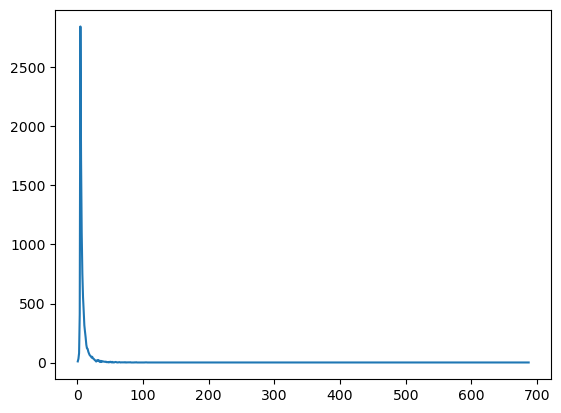

In [53]:
plt.plot(list(fdct.keys()), list(fdct.values()))